#**Problem Statement**

Homonyms are words that share the same spelling or form (characters) but possess distinct meanings. For instance, the term **"bank"** can assume two disparate contexts, denoting both a *"financial institution"* and the *"edge of a river."*

### Relevance in Sentiment Analysis
Homonyms hold significant relevance in sentiment analysis, given their capacity to alter the meaning or emotional tone of a sentence entirely. Consider the following examples that highlight this challenge:

#### Examples:
1. **Sentence 1**: "I hate the selfishness in you"  
   **Label**: *NEGATIVE*  

2. **Sentence 2**: "I hate anyone who hurts you"  
   **Label**: *POSITIVE*  

### Analysis of Contextual Impact
- In the first sentence, the word **"hate"** renders the sentiment as *NEGATIVE*.
- Conversely, in the second sentence, the same word, **"hate,"** appears but shapes the sentiment as *POSITIVE*.

### Challenges for Fixed Word Embeddings
This poses a considerable challenge to models relying on fixed word embeddings, as these embeddings treat words as having static meanings, neglecting contextual nuances.

### Solution: Contextualized Embeddings
To address this issue, employing **contextualized embeddings** leveraging **attention mechanisms** from **transformers** becomes crucial. Models like **BERT** and **GPT** are capable of grasping the comprehensive context within a sentence, allowing them to differentiate meanings based on surrounding words and sentence structures.

### Key Takeaway
Context-aware models enhance sentiment analysis by dynamically interpreting word meanings, thus overcoming the limitations of static embeddings when dealing with homonyms and ambiguous language structures.



#**Install required packages**

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.7 MB/s eta 0:00:00
  

#**Dataset investigation**

[The Stanford Sentiment Treebank](https://https://huggingface.co/datasets/stanfordnlp/sst2) is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11,855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215,154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

In [2]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.head()

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0


In [4]:
df['label_str'] = df['label'].map({0: 'negative', 1: 'positive'})

In [ ]:
df.head(2)

,idx,sentence,label,label_str
0,0,hide new secretions from the parental units,0,negative
1,1,"contains no wit , only labored gags",0,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idx        67349 non-null  int32 
 1   sentence   67349 non-null  object
 2   label      67349 non-null  int64 
 3   label_str  67349 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 1.8+ MB


In [6]:
df['label_str'].value_counts()


,count
label_str,
positive,37569
negative,29780


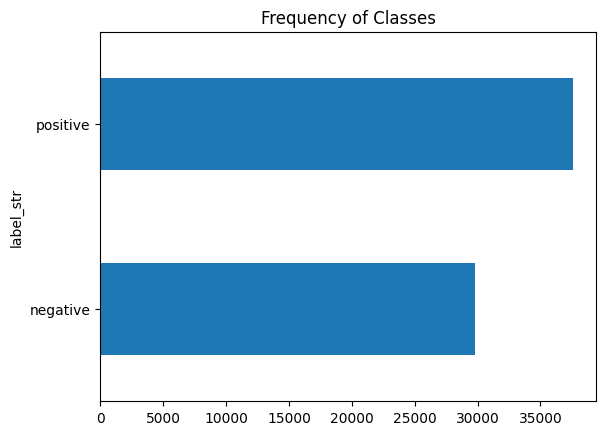

In [7]:
import matplotlib.pyplot as plt
label_counts = df['label_str'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

**Observing a slight class imbalance**

<Axes: title={'center': 'Words_per_review'}, xlabel='label_str'>

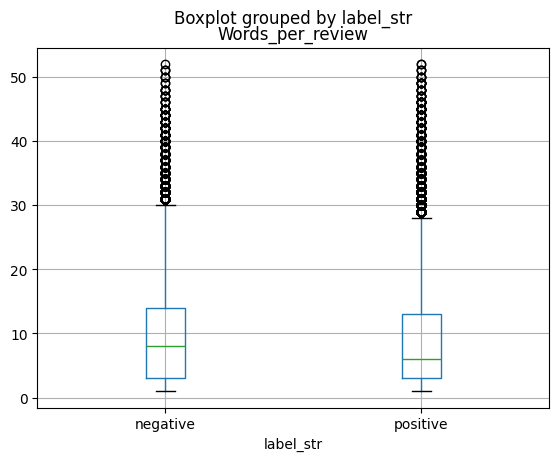

In [8]:
df['Words_per_review'] = df['sentence'].str.split().apply(len)
df.boxplot("Words_per_review", by="label_str")

In [9]:
df.head()

,idx,sentence,label,label_str,Words_per_review
0,0,hide new secretions from the parental units,0,negative,7
1,1,"contains no wit , only labored gags",0,negative,7
2,2,that loves its characters and communicates som...,1,positive,12
3,3,remains utterly satisfied to remain the same t...,0,negative,8
4,4,on the worst revenge-of-the-nerds clichés the ...,0,negative,10


#**Balancing dataset**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X = train_padded_sequences
y = df_train["label"]
print(f"Original label counts:\n{Counter(y)}\n")

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print(f"Oversampled label counts:\n{Counter(y_res)}\n")

#**Text to Tokens Conversion**
- Transformer models like BERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
- Tokenization is the step of breaking down a string into the atomic units used in the model

##**Test example**

In [10]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [11]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length


(30522, 30522, 512)

#**Data loader and train_test_split**

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_str'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_str'])

train.shape, test.shape, validation.shape

((47144, 5), (13470, 5), (6735, 5))

In [13]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }

)

dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review'],
        num_rows: 47144
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review'],
        num_rows: 13470
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review'],
        num_rows: 6735
    })
})

In [14]:
dataset['train'][0], dataset['train'][1]


({'idx': 51492,
  'sentence': 'flopped as surely ',
  'label': 0,
  'label_str': 'negative',
  'Words_per_review': 3},
 {'idx': 40957,
  'sentence': 'bolstered by exceptional performances and a clear-eyed take on the economics of dealing and the pathology of ghetto fabulousness . ',
  'label': 1,
  'label_str': 'positive',
  'Words_per_review': 20})

In [15]:
def tokenize(batch):
    temp = tokenizer(batch['sentence'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 24723, 2004, 7543, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 8945, 29576, 2098, 2011, 11813, 4616, 1998, 1037, 3154, 1011, 7168, 2202, 2006, 1996, 5543, 1997, 7149, 1998, 1996, 19314, 1997, 17276, 18783, 2791, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}




 **1. Input IDs**
- **Definition**: Input IDs are numerical representations of tokens (words or subwords) in the input text.
- **Purpose**: They are passed into the model to identify which tokens are part of the input.
- **How It Works**:
  - Each token in the input is converted to an ID based on the tokenizer's vocabulary.
  - Special tokens such as `[CLS]` (classification) and `[SEP]` (separator) are added to the sequence.
- **Example**:
  Text: *"Hello, world!"*
  Tokenized: `["[CLS]", "hello", ",", "world", "!", "[SEP]"]`
  Input IDs: `[101, 7592, 1010, 2088, 999, 102]`

  Here, `101` and `102` are special token IDs for `[CLS]` and `[SEP]` respectively.

---

 **2. Attention Masks**
- **Definition**: Attention masks indicate which tokens in the input sequence should be attended to by the model.
- **Purpose**: They help the model differentiate between real tokens and padding tokens.
- **How It Works**:
  - Tokens that should be attended to (actual words) are marked as `1`.
  - Padding tokens (used to make all input sequences the same length) are marked as `0`.
- **Example**:
  Input IDs: `[101, 7592, 1010, 2088, 999, 102, 0, 0]`
  Attention Mask: `[1, 1, 1, 1, 1, 1, 0, 0]`

  Here, the zeros in the attention mask ensure the model ignores padding tokens.

---

 **3. TokenType IDs**
- **Definition**: TokenType IDs (also called segment IDs) distinguish between different segments of input text.
- **Purpose**: Used in tasks involving sentence pairs (e.g., question-answering), TokenType IDs help the model differentiate between the two sentences.
- **How It Works**:
  - Tokens from the first sentence are assigned `0`.
  - Tokens from the second sentence are assigned `1`.
- **Example**:
  Input: *"What is your name? [SEP] My name is John."*
  Input IDs: `[101, 2054, 2003, 2115, 2171, 102, 2026, 2171, 2003, 2198, 102]`
  TokenType IDs: `[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]`

  Here, TokenType IDs distinguish tokens in the first and second sentences.

---


| Feature              | Purpose                                                                                         | Example                                                                                                  |
|----------------------|-------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| **Input IDs**         | Encodes text tokens as numerical IDs.                                                           | `[101, 7592, 1010, 2088, 999, 102]`                                                                      |
| **Attention Masks**   | Marks real tokens (`1`) and padding tokens (`0`).                                               | `[1, 1, 1, 1, 1, 1, 0, 0]`                                                                              |
| **TokenType IDs**     | Distinguishes segments (e.g., Sentence A: `0`, Sentence B: `1`).                                | `[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]`                                                                      |

---



In [16]:
imdb_encoded = dataset.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/47144 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

In [17]:
imdb_encoded

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 47144
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13470
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'label_str', 'Words_per_review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6735
    })
})

In [18]:
label2id = {x['label_str']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'negative': 0, 'positive': 1}, {0: 'negative', 1: 'positive'})

#**Model Building**

In [19]:
from transformers import AutoModel
import torch

In [20]:
model = AutoModel.from_pretrained(model_ckpt)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
model.config.id2label


{0: 'LABEL_0', 1: 'LABEL_1'}

In [22]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#**Model Finetuning**

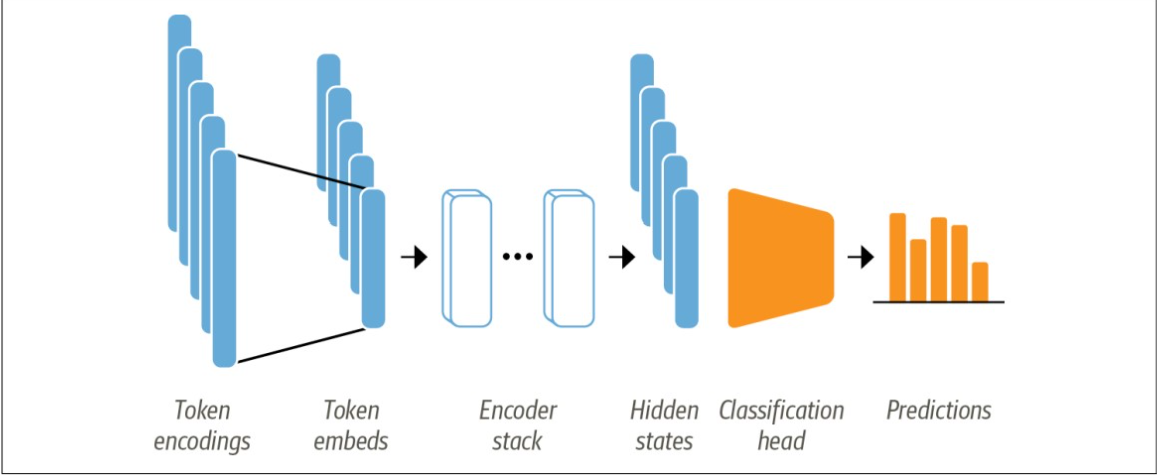

- The first thing we need is a pretrained BERT model like the one we used in the feature-based approach.
- The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of AutoModel.
- The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

In [23]:
num_labels = len(label2id)


In [24]:
num_labels

2

In [25]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model.config


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#**Trainer**

##**Training Args**

In [32]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False,
                                  report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00


##**Eval Metrics**

In [29]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [33]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = imdb_encoded['train'],
                  eval_dataset = imdb_encoded['validation'],
                  tokenizer = tokenizer)

<ipython-input-33-23922c5a90b5>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


In [34]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.252000,0.151614,0.940609,0.940547
2,0.153700,0.152472,0.948181,0.948215


TrainOutput(global_step=1474, training_loss=0.17432902528925862, metrics={'train_runtime': 1094.6894, 'train_samples_per_second': 86.132, 'train_steps_per_second': 1.347, 'total_flos': 3197933989050240.0, 'train_loss': 0.17432902528925862, 'epoch': 2.0})

#**Model Evaluation**

In [35]:
preds_output = trainer.predict(imdb_encoded['test'])
preds_output.metrics

{'test_loss': 0.1621757447719574,
 'test_accuracy': 0.9469933184855234,
 'test_f1': 0.9470006219477297,
 'test_runtime': 52.0099,
 'test_samples_per_second': 258.989,
 'test_steps_per_second': 4.057}

In [36]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = imdb_encoded['test'][:]['label']

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5956
           1       0.95      0.95      0.95      7514

    accuracy                           0.95     13470
   macro avg       0.95      0.95      0.95     13470
weighted avg       0.95      0.95      0.95     13470



##**Confusion matrix**

In [38]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

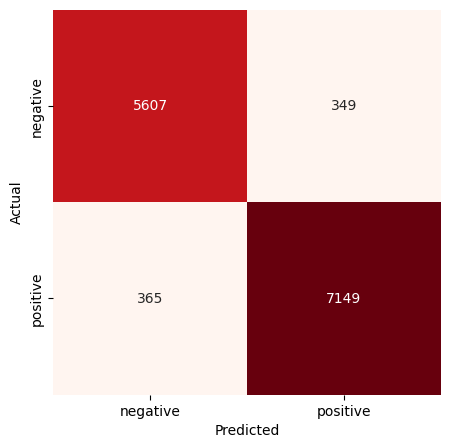

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [40]:
text = "I hate the selfishness in you"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=-1).item()
    return id2label[pred]

get_prediction(text)

'negative'

In [41]:
get_prediction("I hate any one who can hurt you")

'negative'

In [44]:
get_prediction("I hate any one, who hurts you")

'negative'

In [47]:
get_prediction("I love any one who is hurting me ")

'positive'

In [48]:
trainer.save_model("bert-base-uncased-sentiment-model-homonyms")


In [55]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [56]:
trainer.save_model("/content/drive/MyDrive/NLP-models")

In [51]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model-homonyms')

classifier(['hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9788574576377869},
 {'label': 'positive', 'score': 0.997329592704773},
 {'label': 'negative', 'score': 0.9956319332122803}]

In [54]:
classifier("I hate any one who is hurting you")

[{'label': 'negative', 'score': 0.921567440032959}]